# Basic Analysis of Network Traffic Traces

In this laboratory, we will explore the basics of network traffic capture. 

## Learning Objectives

By the end of this lab, you should understand the following:

* How to capture a network traffic trace.
* What the meaining of the following fields are in the trace: (1) IP Address; (2) MAC Address; (3) Length; (4) DNS queries and responses.

## Setup

Before we get started, you will need to install a tool to generate packet captures. There are some example pcaps in the `pcaps` directory of this repository, as well, but it is good for everyone to become familiar with how to perform their own network traffic capture.

**Wireshark** The fundamental data that we will use for analysis, in this laboratory and others, is a _network packet trace_, sometimes called a "pcap".  [Wireshark](https://wireshark.org/) is a tool that we can use to capture and analyze network traffic data from the devices on a network. 

### Warmup: Basic Wireshark Analysis

First, you should use wireshark to collect a packet trace. Save the trace as a regular pcap (not pcapng) somewhere on your local machine. Note the location where you have saved the file, as we will be loading that file into the notebook later.

Using Wireshark answer the following questions:
* How many packets are in the trace?
* What is the total volume of traffic in the trace?

These are fairly straightforward questions that wireshark itself can easily tell you. Doing more complicated analysis (and eventually machine learning) requires more sophisticated processing. For that, in this course, we will rely on Python, pandas, and scikit-learn.

## Analyzing Packet Captures in Python

We will now load the packet capture you have generated into Python---specifically, and analysis library called Pandas, which will allow us to ask more complex questions.  This 

In [1]:
import pandas as pd
from datetime import datetime, timezone

# Allow us to load modules from the parent directory
import sys
sys.path.append("../lib") 
from parse_pcap import pcap_to_pandas, send_rates

# Insert your own packet capture here.

pcap = pcap_to_pandas('../pcaps/pcap-20210604.pcap')
#pcap = pcap_to_pandas('../pcaps/uchicagocs-web-20200821.pcap')

# look at the first n rows of the packet capture
pcap.head(10)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,837,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,57923.0,UDP,1622860587.038075,0.000000
1,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,966,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,57923.0,UDP,1622860587.038076,0.000001
2,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,965,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,57923.0,UDP,1622860587.038116,0.000041
3,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,353,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,51065.0,UDP,1622860587.038237,0.000162
4,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,764,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,64953.0,UDP,1622860587.046919,0.008844
5,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,763,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,64953.0,UDP,1622860587.046999,0.008924
6,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,1247,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,57923.0,UDP,1622860587.058169,0.020094
7,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,1247,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,57923.0,UDP,1622860587.058170,0.020095
8,2021-06-04 21:36:27,None,None,134.224.187.167,2.262875e+09,192.168.1.58,3.232236e+09,False,374,f4:92:bf:88:17:8b,268911115769739,a0:78:17:a1:d6:d0,176437653001936,8801.0,51065.0,UDP,1622860587.058170,0.020095
9,2021-06-04 21:36:27,None,None,192.168.1.58,3.232236e+09,134.224.187.167,2.262875e+09,False,69,a0:78:17:a1:d6:d0,176437653001936,f4:92:bf:88:17:8b,268911115769739,64953.0,8801.0,UDP,1622860587.059780,0.021705


### Basic Dataframe Statistics

You can use the `shape` function to discover how many rows and columns exist in your dataset and the `columns` function to get a list of column headers.

In [2]:
print('{}\n\n'.format(pcap.shape))
print(pcap.columns)

(2816, 18)


Index(['datetime', 'dns_query', 'dns_resp', 'ip_dst', 'ip_dst_int', 'ip_src',
       'ip_src_int', 'is_dns', 'length', 'mac_dst', 'mac_dst_int', 'mac_src',
       'mac_src_int', 'port_dst', 'port_src', 'protocol', 'time',
       'time_normed'],
      dtype='object')


### Slicing and Sub-Selecting Data

Pandas allows the use of slicing to subselect columns. Let's use that function to cut down our list of columns to some columns on which we want to do further analysis.

In [3]:
pcap = pcap.loc[:,['datetime','ip_src','ip_dst',
                   'length','port_src','port_dst','protocol']]
pcap.head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
0,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,837,57923.0,8801.0,UDP
1,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,966,57923.0,8801.0,UDP
2,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,965,57923.0,8801.0,UDP
3,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,353,51065.0,8801.0,UDP
4,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,764,64953.0,8801.0,UDP
5,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,763,64953.0,8801.0,UDP
6,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
7,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
8,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,374,51065.0,8801.0,UDP
9,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,69,8801.0,64953.0,UDP


### Conditional Slicing

You can slice a dataframe based on conditionals.  Here we select only the rows whose source IP address corresponds to a certain value.

For example, let's look at a sample of all of the packets in the **"upstream"** direction (i.e., from the laptop/browser to the webserver).

In [4]:
local_ip = '192.168.1.58'
pcap[pcap['ip_src'] == local_ip].head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
0,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,837,57923.0,8801.0,UDP
1,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,966,57923.0,8801.0,UDP
2,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,965,57923.0,8801.0,UDP
3,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,353,51065.0,8801.0,UDP
4,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,764,64953.0,8801.0,UDP
5,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,763,64953.0,8801.0,UDP
6,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
7,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
8,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,374,51065.0,8801.0,UDP
13,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP


Similarly, we can look at the value of packets in the **downstream** direction.

In [5]:
pcap[pcap['ip_dst'] == local_ip].head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
9,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,69,8801.0,64953.0,UDP
10,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,599,8801.0,57923.0,UDP
11,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,922,8801.0,57923.0,UDP
12,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,791,8801.0,57923.0,UDP
16,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,778,8801.0,57923.0,UDP
17,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,924,8801.0,57923.0,UDP
27,2021-06-04 21:36:27,3.211.86.134,192.168.1.58,705,443.0,50856.0,TCP
29,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,69,8801.0,64953.0,UDP
30,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,1207,8801.0,57923.0,UDP
33,2021-06-04 21:36:27,134.224.187.167,192.168.1.58,123,8801.0,64953.0,UDP


### Questions

1. How many packets larger than 500 bytes in the upstream direction?

In [6]:
big_upstream = pcap[(pcap['ip_src'] == local_ip) & (pcap['length'] > 500)]
big_upstream.head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
0,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,837,57923.0,8801.0,UDP
1,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,966,57923.0,8801.0,UDP
2,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,965,57923.0,8801.0,UDP
4,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,764,64953.0,8801.0,UDP
5,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,763,64953.0,8801.0,UDP
6,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
7,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
13,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
14,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,1247,57923.0,8801.0,UDP
19,2021-06-04 21:36:27,192.168.1.58,134.224.187.167,732,57923.0,8801.0,UDP


In [7]:
big_upstream.shape

(1392, 7)

2. What is the average size of packets in upstream and downstream directions?

In [8]:
# upstream mean length
pcap[pcap['ip_src'] == local_ip]['length'].mean()

796.4340490797546

In [9]:
# downstream mean length
pcap[pcap['ip_dst'] == local_ip]['length'].mean()

520.7646370023419

### Plotting

In [10]:
# Plotting Library
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

#### Histogram

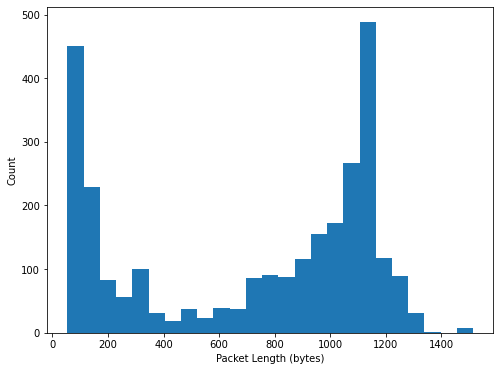

In [11]:
num_bins = 25
plt.xlabel('Packet Length (bytes)')
plt.ylabel('Count')
plt.hist(pcap['length'], num_bins)
plt.show()

#### Timeseries Plots

In [12]:
import seaborn as sns

In [13]:
upstream = pcap[pcap['ip_src'] == local_ip]
downstream = pcap[pcap['ip_dst'] == local_ip]

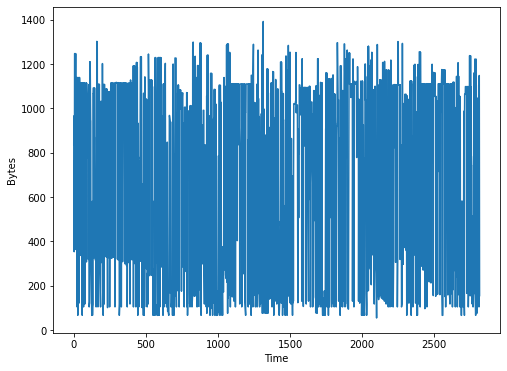

In [14]:
plt.xlabel('Time')
plt.ylabel('Bytes')

upstream['length'].plot(linewidth=1.5)
plt.show()

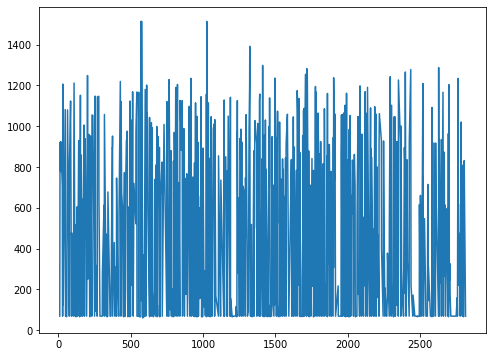

In [15]:
downstream['length'].plot(linewidth=1.5)
plt.show()

----
### Further Analysis Questions

You could ask some follow up questions about the web download above:
* How many total bytes were exchanged in this web download (in both directions)? 
* How many total bytes went from the web server to the client device (e.g., web browser) ("download"))?
* How long did the total download take?
* What is the maximum packet size (length)? What is the average packet size?
* How many unique flows are in the trace?

You may find the Pandas documentation and examples helpful. (e.g., [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html))

In [16]:
# Total bytes exchanged.
# HINT: use the pandas slicing and aggregation functions.

tbytes = pcap['length'].sum()

print('There were {} bytes exchanged.'.format(tbytes))

# Total bytes downloaded.
# HINT: extend the first part by first using a conditional slice to only select the download packets.
# (download would be ip_dst equal to the IP address of the client, ip_src equal to the IP address of the server)

dlbytes = pcap[pcap['ip_dst'] == local_ip]['length'].sum()
ulbytes = pcap[pcap['ip_src'] == local_ip]['length'].sum()

print('Download: {} bytes.'.format(dlbytes))
print('Upload: {} bytes.'.format(ulbytes))

There were 2002918 bytes exchanged.
Download: 444733 bytes.
Upload: 1557825 bytes.


In [17]:
# Total time.
# HINT: Time of last row minus time of first row.

starttime = pcap.iloc[0,:]['datetime']
endtime = pcap.iloc[-1,:]['datetime']

tt = endtime - starttime

print('This trace is {} seconds long.'.format(tt.seconds))

This trace is 7 seconds long.


In [18]:
# Max/average length.
# HINT: Apply max, mean pandas functions to the 'length' column of the pcap dataframe.

lmean = pcap['length'].mean()
lmin = pcap['length'].min()
lmax = pcap['length'].max()

print('Mean: {} \nMin: {} \nMax: {}'.format(lmean, lmin, lmax))

Mean: 711.2634943181819 
Min: 54 
Max: 1514


In [19]:
# Number of unique flows (unique [src IP, dst IP, src port, dst port, protocol])
import numpy as np

pcap['packets'] = 1
unique_flows = pcap.groupby(['ip_src', 'ip_dst', 'port_src', 'port_dst', 'protocol'])

udf = pd.DataFrame(unique_flows.agg(np.sum))

print('There are {} unique flows in the trace.'.format(len(udf)))
udf

There are 90 unique flows in the trace.


length  packets
ip_src          ip_dst       port_src port_dst protocol                 
107.152.29.202  192.168.1.58 443.0    53440.0  TCP          519        2
                                      53486.0  TCP         3893        7
134.224.187.167 192.168.1.58 443.0    52571.0  TCP         9769       46
                             8801.0   51065.0  UDP          123        1
                                      57923.0  UDP       395557      524
...                                                         ...      ...
52.2.208.199    192.168.1.58 443.0    50629.0  TCP          189        2
                                      50762.0  TCP          189        2
                                      50767.0  TCP          189        2
54.163.224.3    192.168.1.58 443.0    50708.0  TCP          189        2
54.164.13.198   192.168.1.58 443.0    50578.0  TCP          123        1

[90 rows x 2 columns]

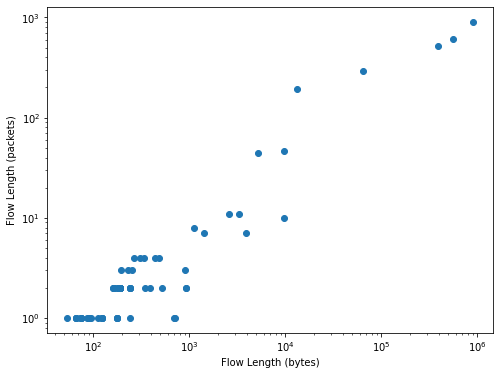

In [20]:
plt.xlabel('Flow Length (bytes)')
plt.ylabel('Flow Length (packets)')
plt.xscale('log')
plt.yscale('log')
plt.scatter(udf['length'],udf['packets'])
plt.show()

---
## Basic Analysis of Traffic Using Pandas

Try some of the examples below using a trace that has multiple destination IP addresses (e.g., all of your web traffic).

### List of Unique Destination IP Addresses

What are the unique destinations that our network is communicating with?  We can use the `unique` function to retrieve those.

In [21]:
unique_dst_ip = pd.DataFrame(pcap['ip_dst'].unique())[0]
print(unique_dst_ip)

0     134.224.187.167
1        192.168.1.58
2        3.211.86.134
3        52.2.208.199
4                None
5       35.186.224.47
6      17.248.190.102
7      17.248.190.136
8       3.225.226.119
9         192.168.1.1
10        3.82.33.168
11       192.168.1.56
12      142.251.6.189
13       157.240.2.53
14      23.22.125.123
15     107.152.29.202
16    142.250.128.189
17    142.250.191.131
18       192.168.1.40
19       54.163.224.3
20     34.200.162.243
21       192.168.1.57
22       192.168.1.51
23      184.72.250.63
24    162.159.133.234
25    255.255.255.255
26      192.168.1.255
27      18.214.50.145
28      54.164.13.198
29        3.80.20.191
30      34.238.21.208
31    192.241.190.165
32     142.250.190.74
Name: 0, dtype: object


### Most Popular Destination IP Addresses

We can group the rows of the dataframe using `groupby`, `sum`, and `sort_values` to determine the most popular destination IP addresses?

In [22]:
pkts_dst = pcap.loc[:,['datetime','ip_dst','length']]
pkts_dst.groupby(['ip_dst']).sum().sort_values(by='length',ascending=False)

,length
ip_dst,
134.224.187.167,1544149
192.168.1.58,444733
142.250.191.131,2628
107.152.29.202,1624
17.248.190.136,1137
255.255.255.255,941
192.168.1.255,941
52.2.208.199,748
3.225.226.119,627


Define a reverse lookup function.

In [23]:
from dns import resolver
from dns import reversename

# test reverse DNS lookup
addr = reversename.from_address('34.193.201.2')
print(resolver.query(addr, "PTR")[0])

ec2-34-193-201-2.compute-1.amazonaws.com.


In [24]:
# test reverse DNS lookup
addr = reversename.from_address('204.80.104.218')
print(resolver.query(addr, "PTR")[0])

zoomnye218mmr.ny.zoom.us.


In [25]:
def reverse_lookup(ip):
    if str(ip) == 'None':
        return 'None'
    addr = reversename.from_address(ip)
    try:
        return str(resolver.query(addr, "PTR")[0])
    except Exception as e:
        return 'N/A'

### Apply a Function to an Entire Dataframe

Use the pandas `apply` function to create a new column with the DNS names associated with each destination. 

Then look at the unique destination IP addresses in the trace.

In [26]:
pcap['name_dst'] = pcap['ip_dst'].apply(reverse_lookup)

In [27]:
unique_dst_name = pd.DataFrame(pcap['name_dst'].unique())[0]
print(unique_dst_name)

0                                             N/A
1       ec2-3-211-86-134.compute-1.amazonaws.com.
2       ec2-52-2-208-199.compute-1.amazonaws.com.
3                                            None
4         47.224.186.35.bc.googleusercontent.com.
5      ec2-3-225-226-119.compute-1.amazonaws.com.
6        ec2-3-82-33-168.compute-1.amazonaws.com.
7             whatsapp-cdn-shv-01-ort2.fbcdn.net.
8      ec2-23-22-125-123.compute-1.amazonaws.com.
9                       ord38s29-in-f3.1e100.net.
10      ec2-54-163-224-3.compute-1.amazonaws.com.
11    ec2-34-200-162-243.compute-1.amazonaws.com.
12     ec2-184-72-250-63.compute-1.amazonaws.com.
13     ec2-18-214-50-145.compute-1.amazonaws.com.
14     ec2-54-164-13-198.compute-1.amazonaws.com.
15       ec2-3-80-20-191.compute-1.amazonaws.com.
16     ec2-34-238-21-208.compute-1.amazonaws.com.
17                            do-39.lastpass.com.
18                     ord37s34-in-f10.1e100.net.
Name: 0, dtype: object


## Functions

It is often useful to encapsulate functionality in functions so that we can use those functions again.

Write functions to count ("sum") the length field so that we can know how much total traffic in bytes is sent to each destination, either by IP address or by name.

In [28]:
def volume_stats_by_ip(pcap):
    return pcap.loc[:,['ip_dst','length']].groupby('ip_dst').sum().sort_values(by=['length'], ascending=False)


def volume_stats_by_name(pcap):
    return pcap.loc[:,['name_dst','length']].groupby('name_dst').sum().sort_values(by=['length'], ascending=False)

In [29]:
volume_stats_by_ip(pcap)

,length
ip_dst,
134.224.187.167,1544149
192.168.1.58,444733
142.250.191.131,2628
107.152.29.202,1624
17.248.190.136,1137
255.255.255.255,941
192.168.1.255,941
52.2.208.199,748
3.225.226.119,627


In [30]:
volume_stats_by_name(pcap)

,length
name_dst,
N/A,1996072
ord38s29-in-f3.1e100.net.,2628
ec2-52-2-208-199.compute-1.amazonaws.com.,748
ec2-3-225-226-119.compute-1.amazonaws.com.,627
ec2-3-211-86-134.compute-1.amazonaws.com.,440
None,360
ec2-54-164-13-198.compute-1.amazonaws.com.,187
ec2-18-214-50-145.compute-1.amazonaws.com.,187
ec2-184-72-250-63.compute-1.amazonaws.com.,187


## Going Further

For homework, define some questions you want to ask about the network traffic trace and write some functions to analyze the trace.

Here are some example questions.  You can pick one of these or define one yourself:
* What is the maximum, median, minimum, and mean packet size?
* How many DNS queries (destination port 53) are there in this trace?
* What is the most popular DNS query in the trace?